<a href="https://colab.research.google.com/github/jfink09/Financial-Modeling/blob/Time-Series-Modeling/Decomposing_Time_series_Using_Facebook_Prophet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Decomposing time series using Facebook Prophet

# Set up plots
%matplotlib inline
%config InclineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt 
import warnings

plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = [16, 9]
plt.rcParams['figure.dpi'] = 300
warnings.simplefilter(action='ignore', category=FutureWarning)

In [0]:
# Addititve model - represented as a combination of patterns on different time scales
# Facebook Prophet - Forcast future values of the time series and indicate uncertainty
# Daily gold prices from 2016-2020 and predicting 2021 prices

# Install Quandl
#!pip install --upgrade quandl
!pip install --upgrade quandl

In [0]:
# Import libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import quandl
from fbprophet import Prophet


# Input your API key from the Quandl account
QUANDL_KEY = '{key}'
quandl.ApiConfig.api_key = QUANDL_KEY

In [0]:
# Download the daily gold prices
df = quandl.get(dataset='WGC/GOLD_DAILY_USD', start_date='2000-01-01', end_date='2005-12-31')

# Display the stock data in a table
df

,Value
Date,
2000-01-03,290.25
2000-01-04,281.50
2000-01-05,280.45
2000-01-06,279.40
2000-01-07,282.10
...,...
2005-12-26,500.00
2005-12-27,500.00
2005-12-28,518.00


In [0]:
# Rename the Date column to ds (the timestamp) and the Value column to y (target variable)
# This (column names) structure is required for Prophet
df.reset_index(drop=False, inplace=True)      # Index the columns
df.rename(columns={'Date': 'ds', 'Value': 'y'}, inplace=True)

# Print data
df

,ds,y
0,2000-01-03,290.25
1,2000-01-04,281.50
2,2000-01-05,280.45
3,2000-01-06,279.40
4,2000-01-07,282.10
...,...,...
1560,2005-12-26,500.00
1561,2005-12-27,500.00
1562,2005-12-28,518.00
1563,2005-12-29,513.00


In [0]:
# Split the series into the training and test sets
# Training years are 2000-2004 and the test year is 2005 
train_indices = df.ds.apply(lambda x: x.year) < 2005
df_train = df.loc[train_indices].dropna()
df_test = df.loc[~train_indices].reset_index(drop=True) 

# Create the instance of the model and fit it to the data
# Run an additive seasonality
# Add monthly seasonality by using add_seasonality with values suggested by Prophet's documentation
model_prophet = Prophet(seasonality_mode='additive')
model_prophet.add_seasonality(name='monthly', period=30.5, fourier_order=5)

# The fit method is known from the scikit-learn library
model_prophet.fit(df_train)

INFO:numexpr.utils:NumExpr defaulting to 2 threads.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


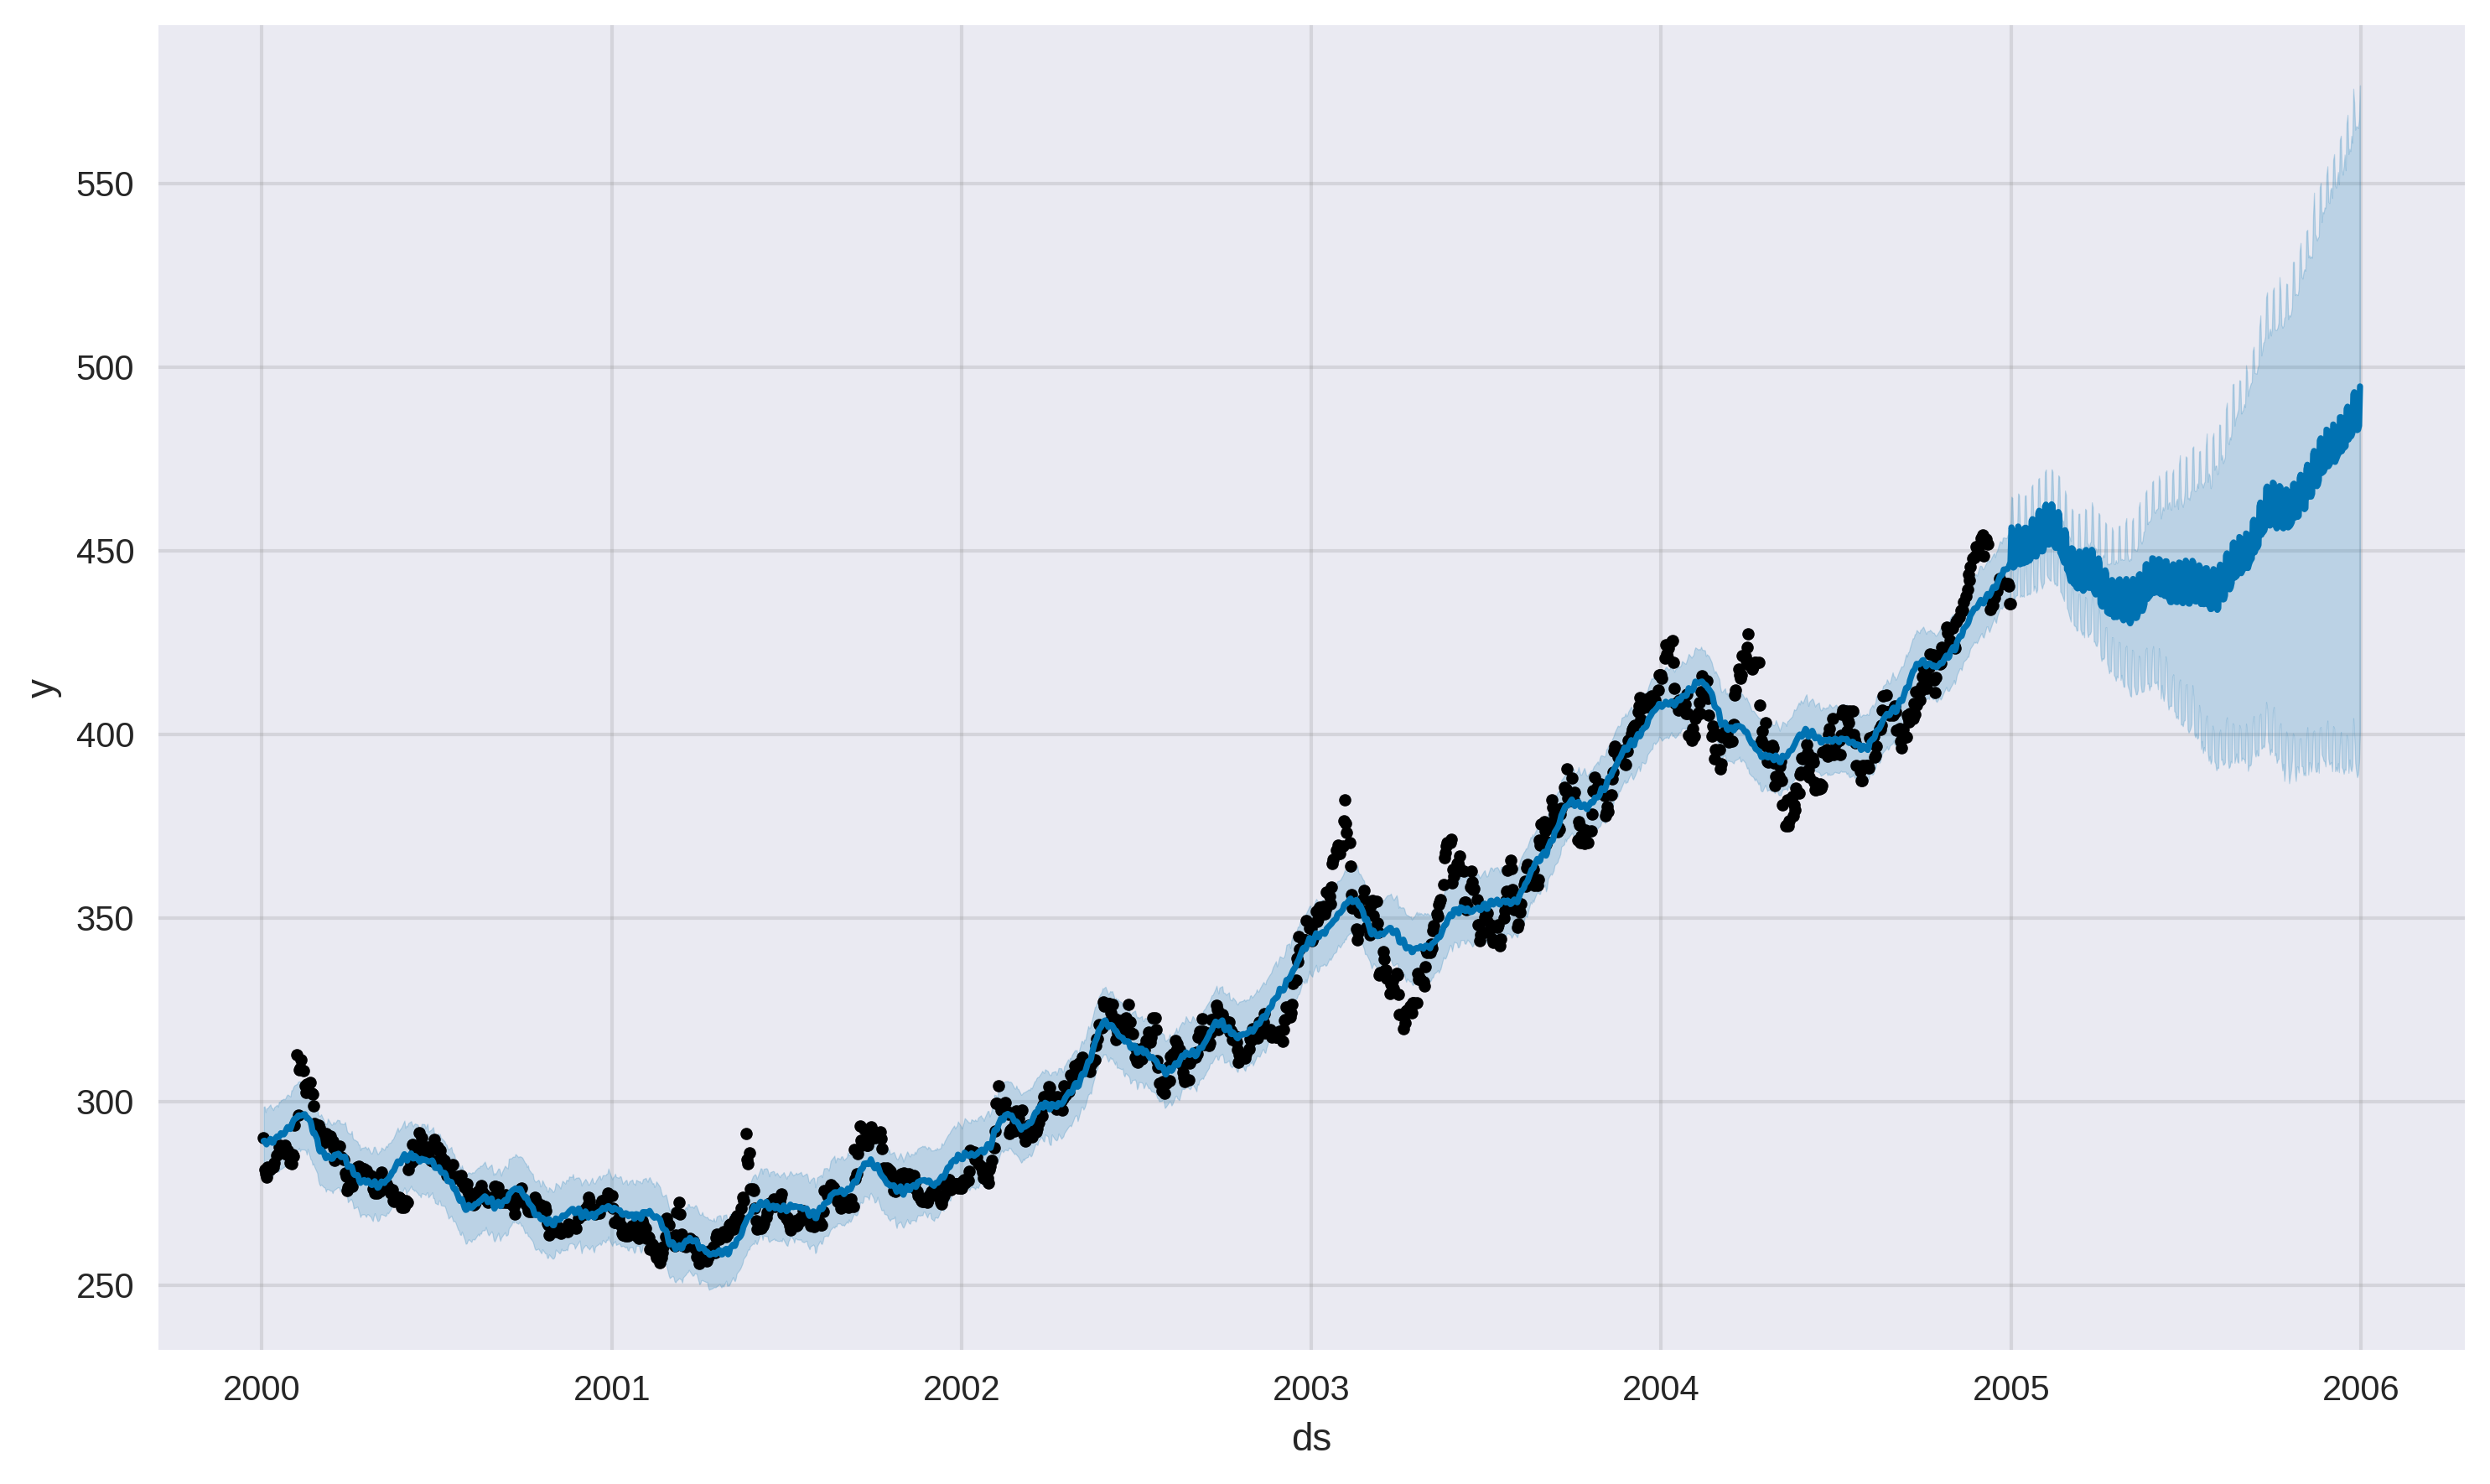

In [0]:
# Forcast the gold prices and plot
# Use the fitted model for predicitions 
# Create a future_dataframe by using the make_future_dataframe method and indicating how many periods we wanted to get (measured in days by default)
df_future = model_prophet.make_future_dataframe(periods=365)

# Create the predictions using the predict method of the fitted model
df_pred = model_prophet.predict(df_future)
model_prophet.plot(df_pred)

# Refine chart layout
plt.tight_layout()
plt.show()

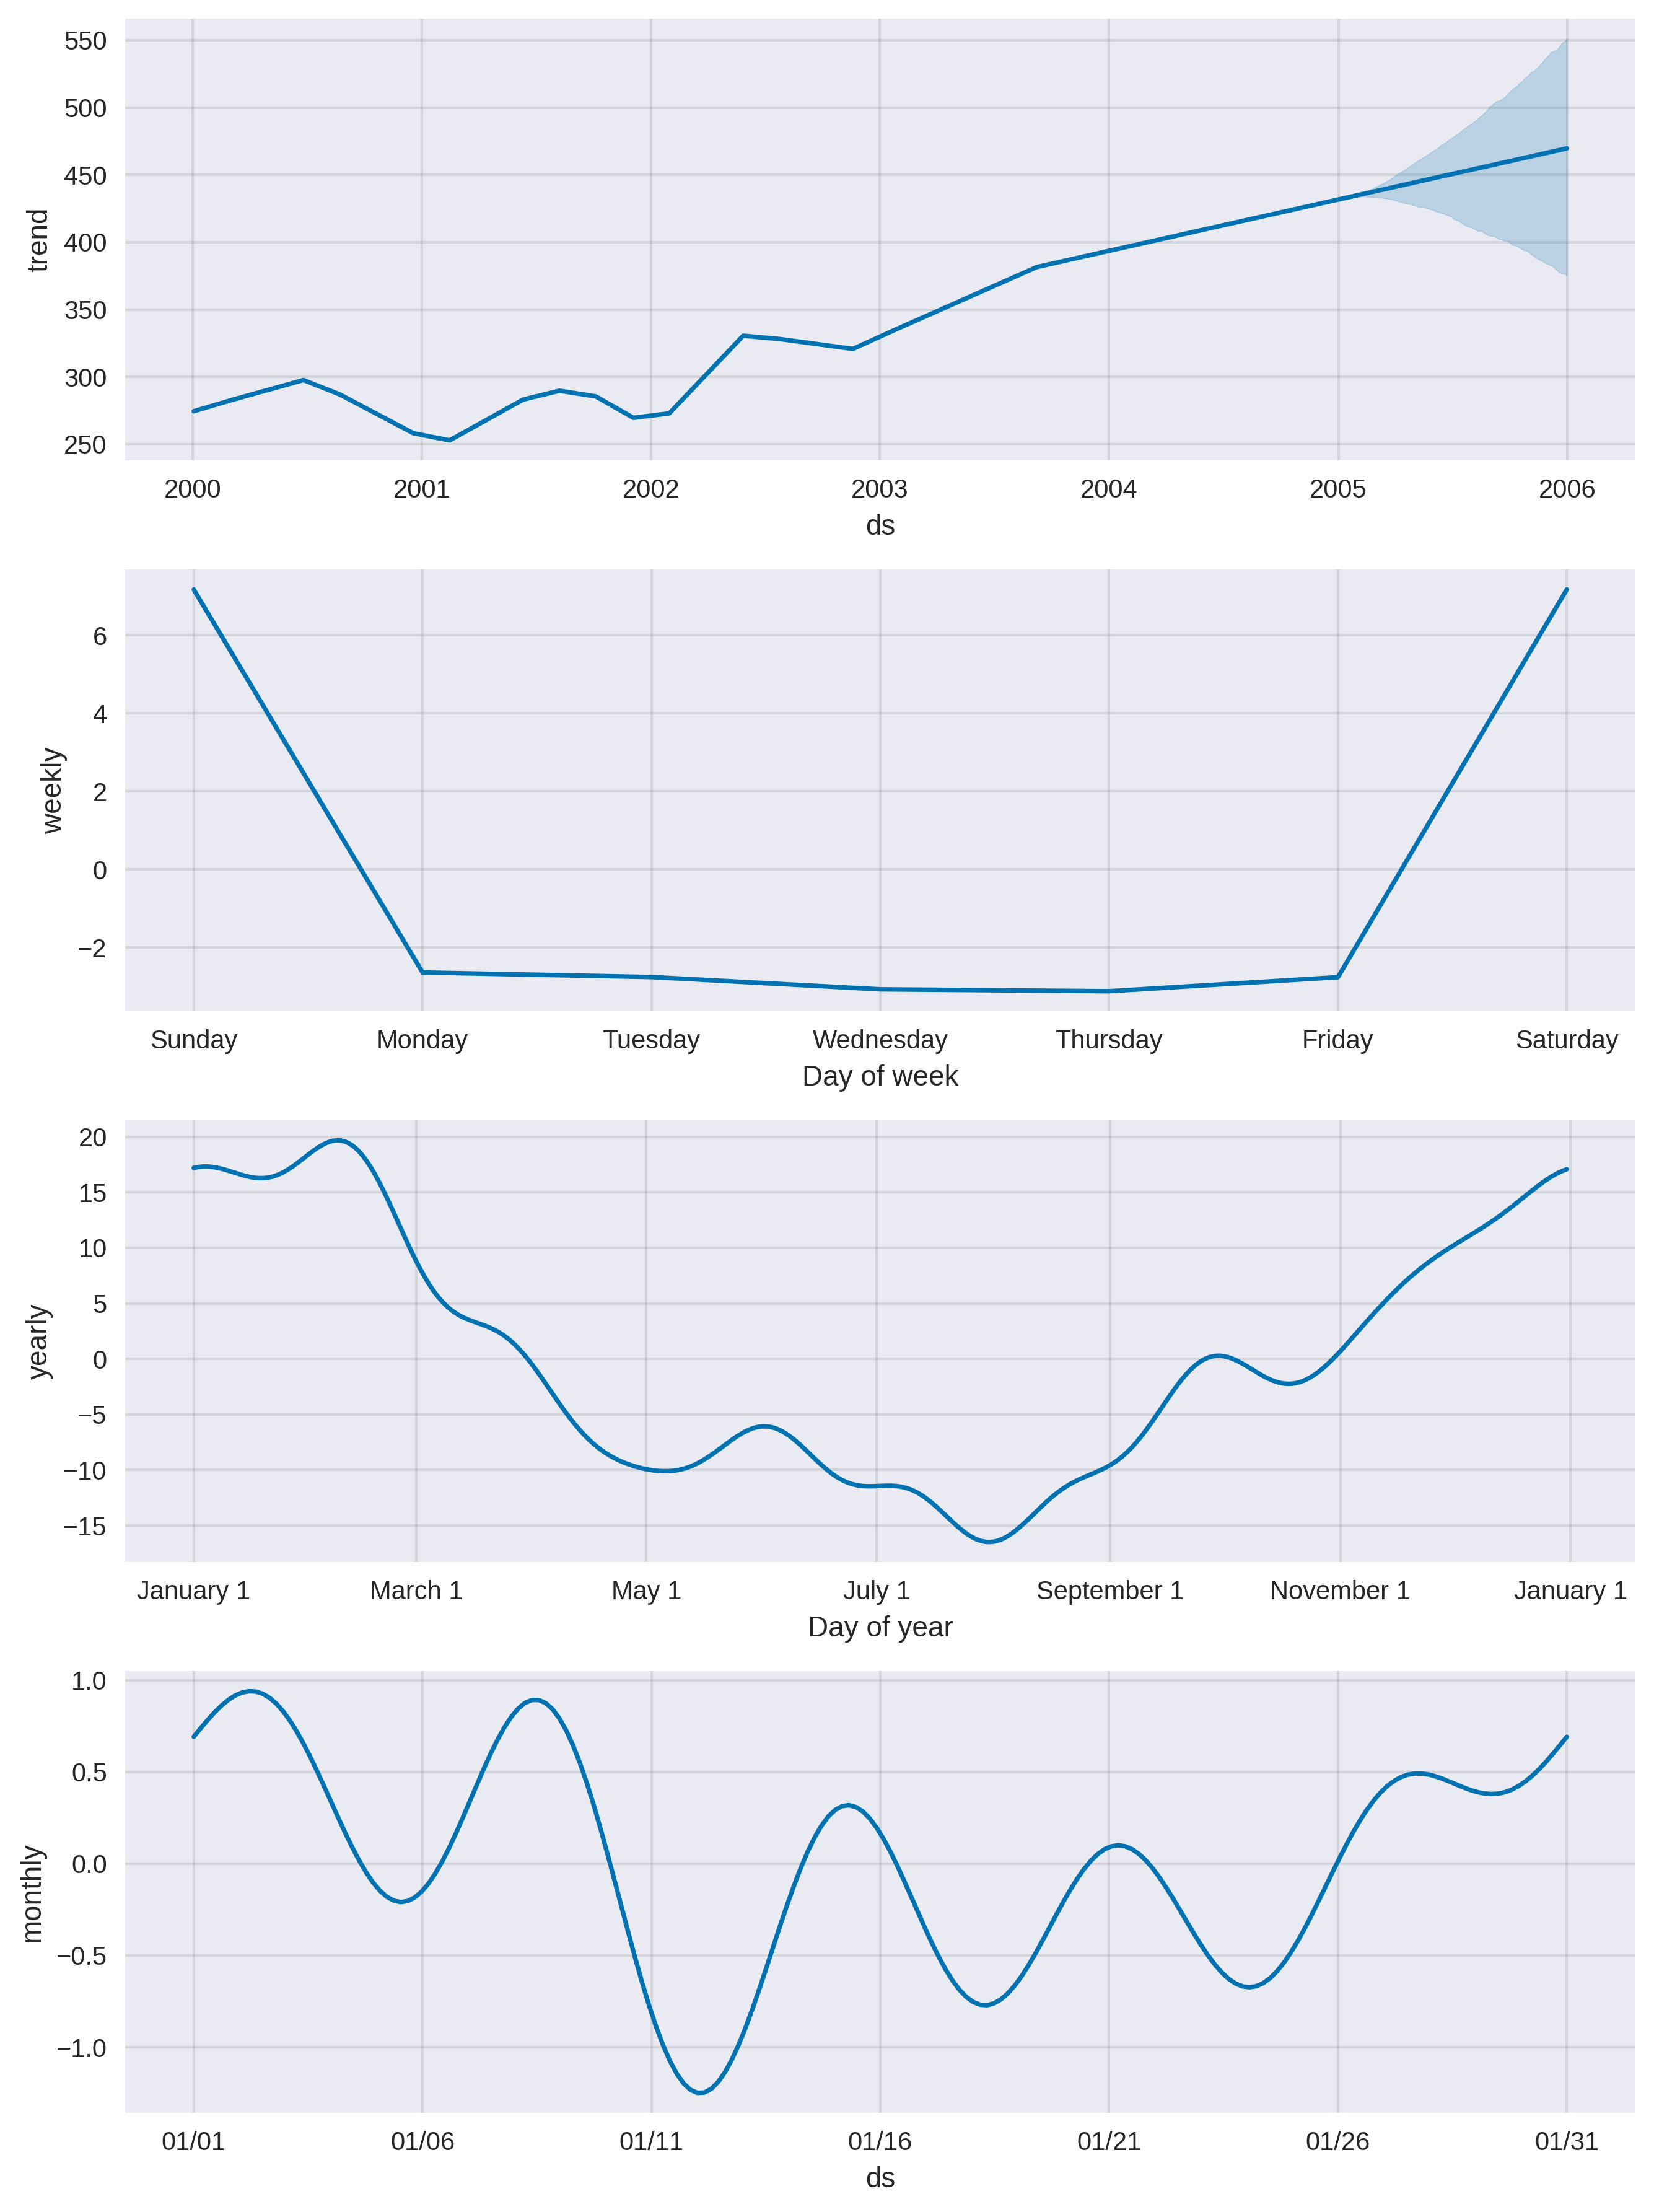

In [0]:
# Inspect the decomposition of the time series
# Use the plot_components method with the prediction DataFrame as an argument
model_prophet.plot_components(df_pred)

# The overall trend is increasing, gold prices seem to be higher during the beginning and end of the year and dips in the summer
# On the monthly chart, there is less movement than the yearly chart
# Not a lot of movement in the weekly chart (excluded weekends since there was no prediction for the weekends)
# A decrease in the time scale, the noise starts to wash out the signal. (Can probably flout the weekly level altogether)

# Refine chart layout
plt.tight_layout()
plt.show()

[Text(0, 0.5, 'Gold Price ($)'),
 Text(0.5, 0, 'Date'),
 Text(0.5, 1.0, 'Gold Price - actual vs. predicted')]

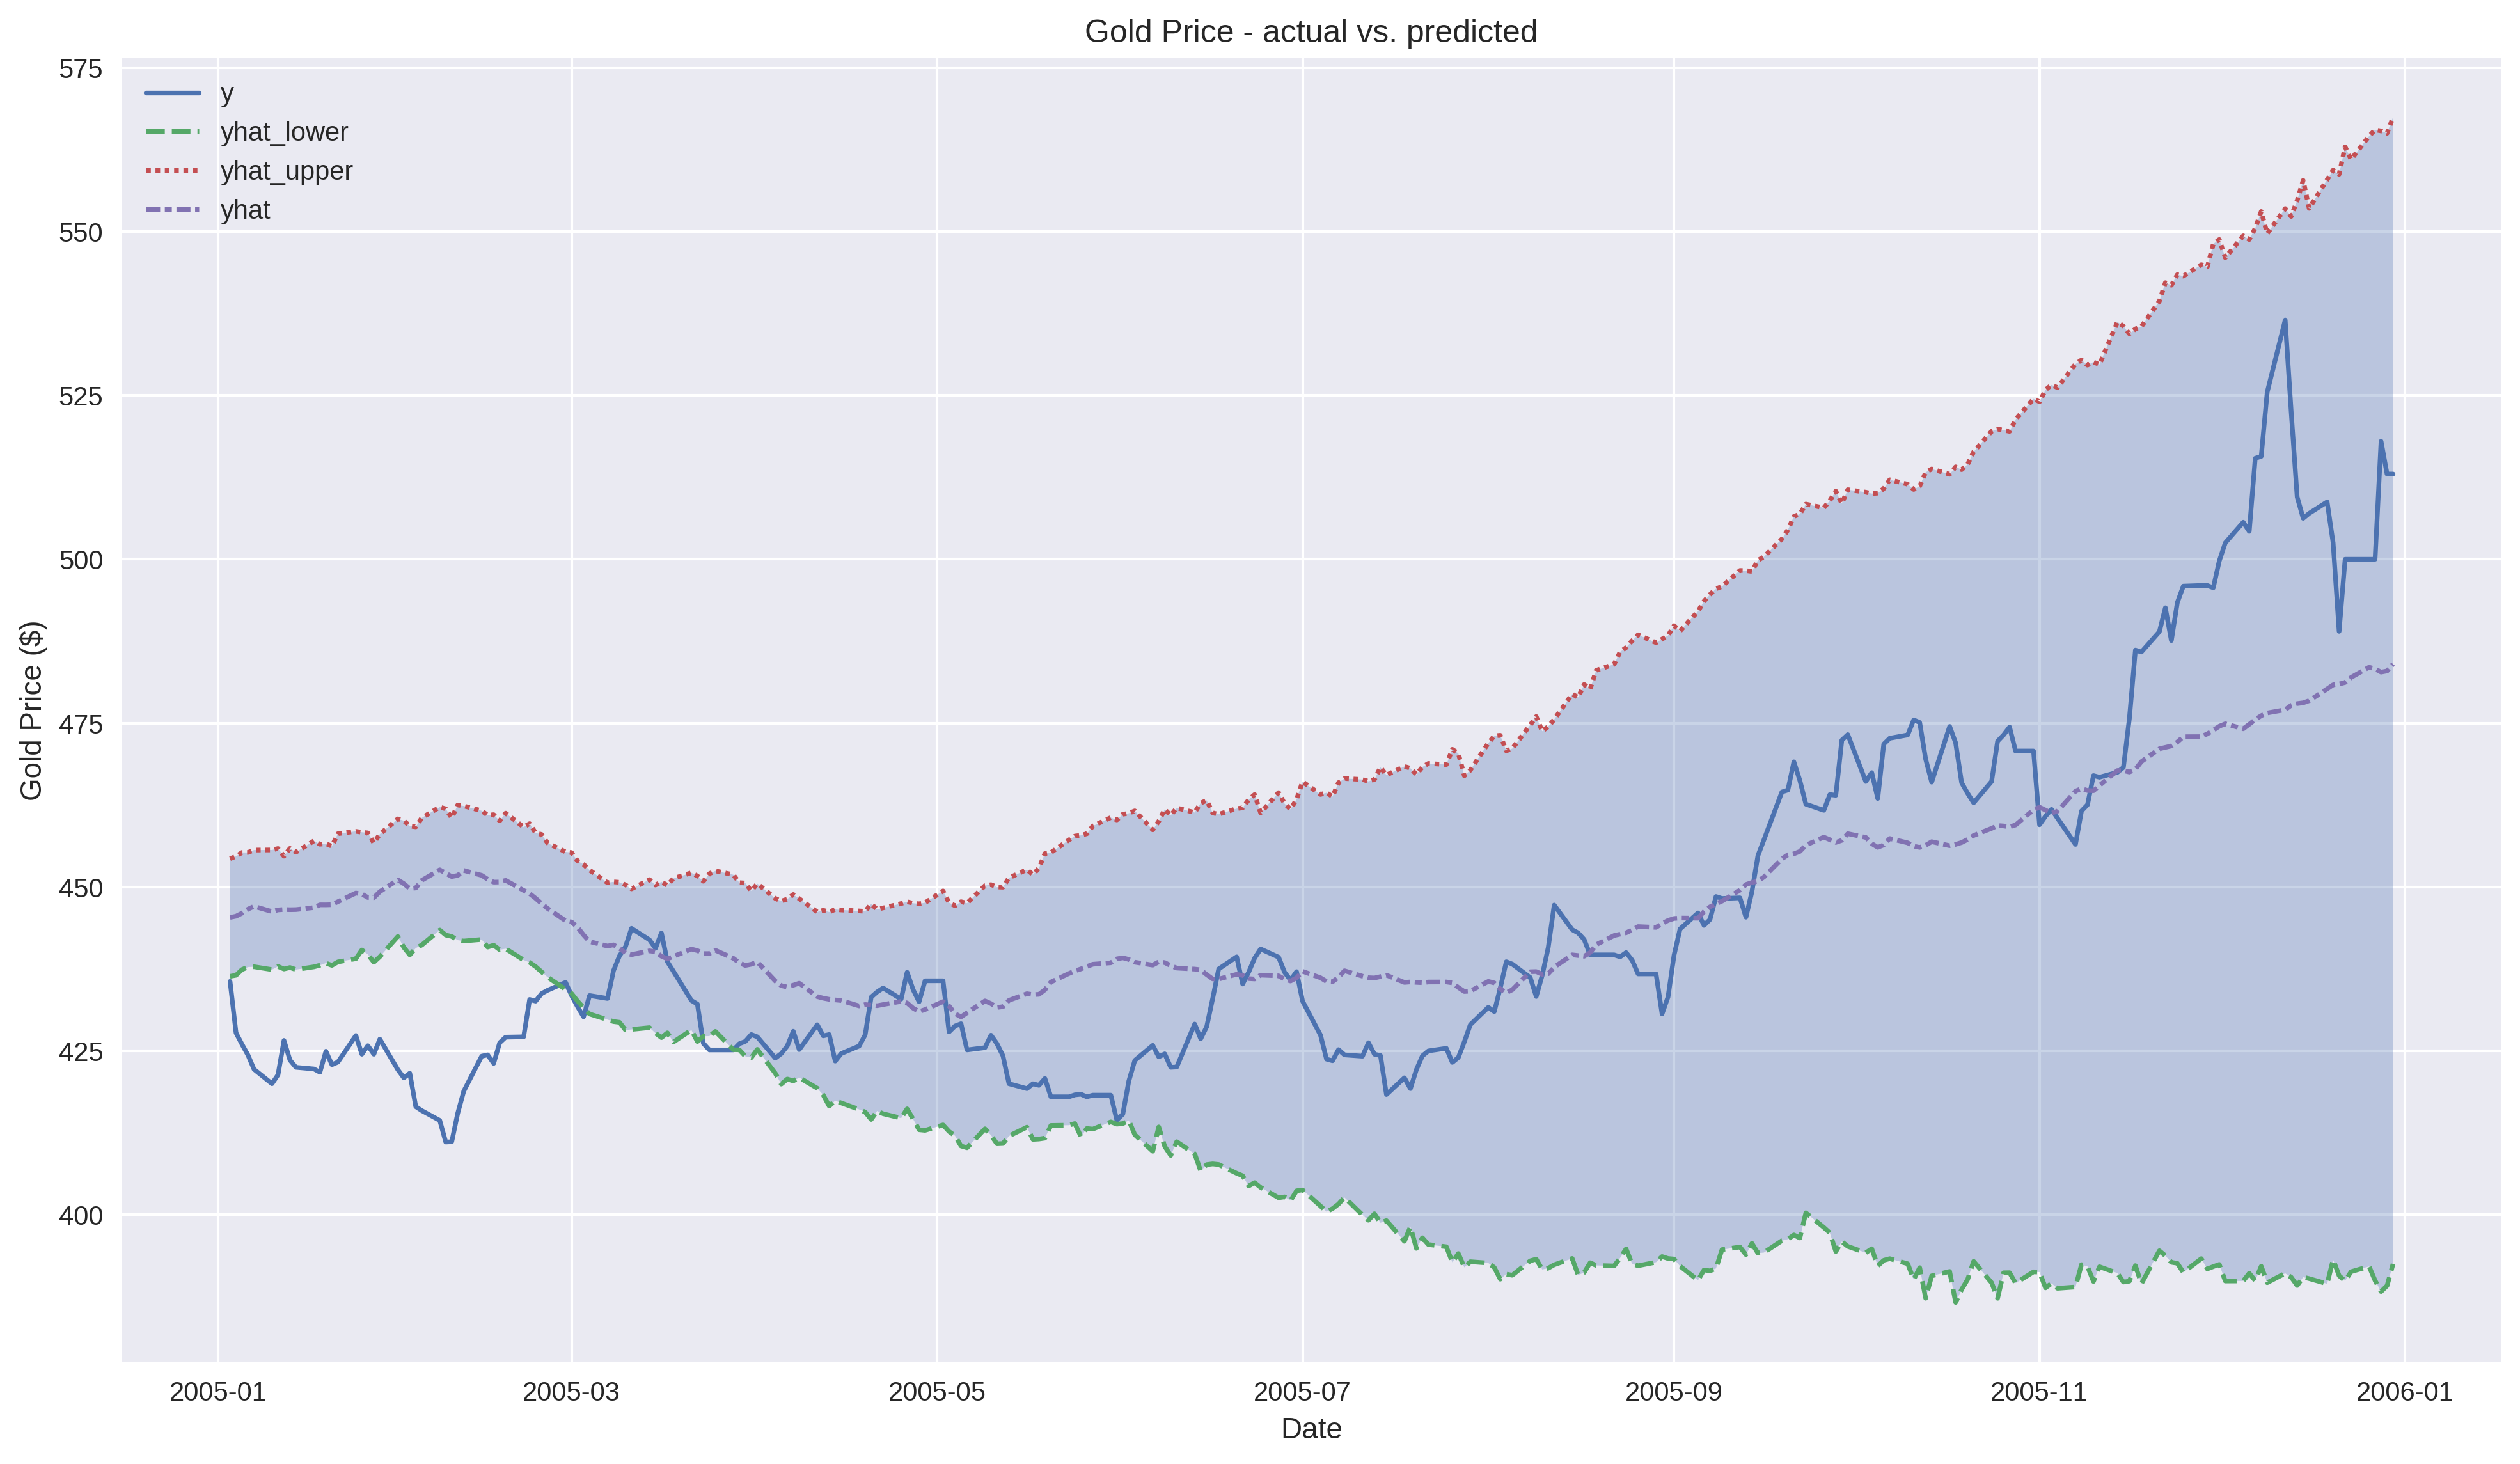

In [0]:
# Basic performance evaluation of the fitted model
# Inspect the predicted versus actual gold prices in 2005
# Merge the test set with the forecasts
selected_columns = ['ds', 'yhat_lower', 'yhat_upper', 'yhat']
df_pred = df_pred.loc[:, selected_columns].reset_index(drop=True)
df_test = df_test.merge(df_pred, on=['ds'], how='left')
df_test.ds = pd.to_datetime(df_test.ds)
df_test.set_index('ds', inplace=True)

# This merged the test set with the prediction DataFrame 
# Used a left join to return all rows from the left table (test set) and matched rows from the right table (prediction DataFrame) and left unmatched rows empty
# This kept only dates that were in the test set (Prophet created prediction for the next 365 days, including weekends and potential holidays)

# Plot the test values versus the prediction
fig, ax = plt.subplots(1,1)
ax = sns.lineplot(data=df_test[['y', 'yhat_lower', 'yhat_upper', 'yhat']])
ax.fill_between(df_test.index, 
                df_test.yhat_lower, 
                df_test.yhat_upper, 
                alpha=0.3)
ax.set(title='Gold Price - actual vs. predicted', xlabel='Date', ylabel='Gold Price ($)')